1.IMPORTING DATA AND REQUIRED PACKAGES

In [2]:
import sys
print(sys.executable)

c:\Users\Kirush\Downloads\Employee_turnover_Analysis_ML_Project\venv\Scripts\python.exe


In [3]:
!c:/Users/Kirush/Downloads/Employee_turnover_Analysis_ML_Project/venv/Scripts/python.exe -m pip install scikit-learn imbalanced-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.7 MB 264.8 kB/s eta 0:00:31
   -- ------------------------------------- 0.5/8.7 MB 264.8 kB/s eta 0:00:31
   -- ------------------------------------- 0.5/8.7 MB 264.8 kB/s eta 0:00:31
   -- ------------------------------------- 0.5/8.7 MB 264.8 kB/s eta 0:00:31
   ---- ----------------------------------- 1.0/8.7 MB 402.9 kB/s e


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
df = pd.read_csv('HR_comma_sep.csv')

In [9]:
#droppingg duplicates
df.drop_duplicates(keep='first',inplace=True)

#renaming the column name 'sales' as 'department'
df.rename(columns = {'sales':'department'}, inplace = True)

#applying one hot encoding
df= pd.get_dummies(data = df, columns = ['department'], drop_first = True)

#applying label encoding
df['salary'] = df['salary'].map({'low':0, 'medium': 1, 'high': 2})

2. DEFINING X AND Y AND PERFORMING TRAIN-TEST SPLIT

In [10]:
x = df.drop(['left'], axis = 1).astype('float64')
y = df['left']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 123)

In [11]:
y_train.value_counts()

left
0    7991
1    1601
Name: count, dtype: int64

Train data is imbalanced!

In [ ]:
#since the values are between 0 to 1 already, thus standard scalling is not used.

#upsampling class 0 to 60% of class 1 using SMOTE
smote = SMOTE(sampling_strategy = 0.8,random_state = 42)
x_train_smote,y_train_smote = smote.fit_resample(x_train,y_train)

In [13]:
y_train_smote.value_counts()

left
0    7991
1    6392
Name: count, dtype: int64

Train data is balanced.

3. FITTING DATA INTO 3 DIFFERENT MODELS & EVALUATING THEIR PERFORMANCE

MODEL 1: Logistic Regression + 5 fold CV

In [14]:
# Pipeline: SMOTE transforms, then Logistic Regression
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

# 5-fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, x, y, cv=cv)

# Classification report
print(classification_report(y, y_pred))
report = classification_report(y, y_pred, output_dict=True)


              precision    recall  f1-score   support

           0       0.96      0.77      0.85     10000
           1       0.41      0.82      0.55      1991

    accuracy                           0.78     11991
   macro avg       0.68      0.79      0.70     11991
weighted avg       0.86      0.78      0.80     11991



MODEL 2: Random Forest Classifier + 5 Fold CV

In [15]:
# Pipeline: SMOTE transforms, then RandomForest classifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('randomforest', RandomForestClassifier(n_estimators=100,n_jobs = -1, random_state=42))
])

# 5-fold Stratified CV
y_pred1 = cross_val_predict(pipeline, x, y, cv=cv)

# Classification report
print(classification_report(y, y_pred1))
report1 = classification_report(y, y_pred1, output_dict=True)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10000
           1       0.98      0.91      0.95      1991

    accuracy                           0.98     11991
   macro avg       0.98      0.96      0.97     11991
weighted avg       0.98      0.98      0.98     11991



MODEL 3: Gradient Boosting Classifier + 5 Fold CV

In [16]:
# Pipeline: SMOTE transforms, then Gradient Boosting classifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('gradientboosting', GradientBoostingClassifier(n_estimators=100,learning_rate = 0.1, random_state=42))
])

# 5-fold Stratified CV
y_pred2 = cross_val_predict(pipeline, x, y, cv=cv)

# Classification report
print(classification_report(y, y_pred2))
report2 = classification_report(y, y_pred2, output_dict=True)


              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10000
           1       0.91      0.93      0.92      1991

    accuracy                           0.97     11991
   macro avg       0.95      0.95      0.95     11991
weighted avg       0.97      0.97      0.97     11991



Clearly the performance of Random Forest Classifier model and Gradient Boosting Classifier are the best with recall value for class 1 as 0.91 and 0.93 respectively.

According to the problem statement, recall is the most important metric because a false negative entry becomes costly for the company.

4.PLOTTING ROC CURVE FOR ALL THE MODELS

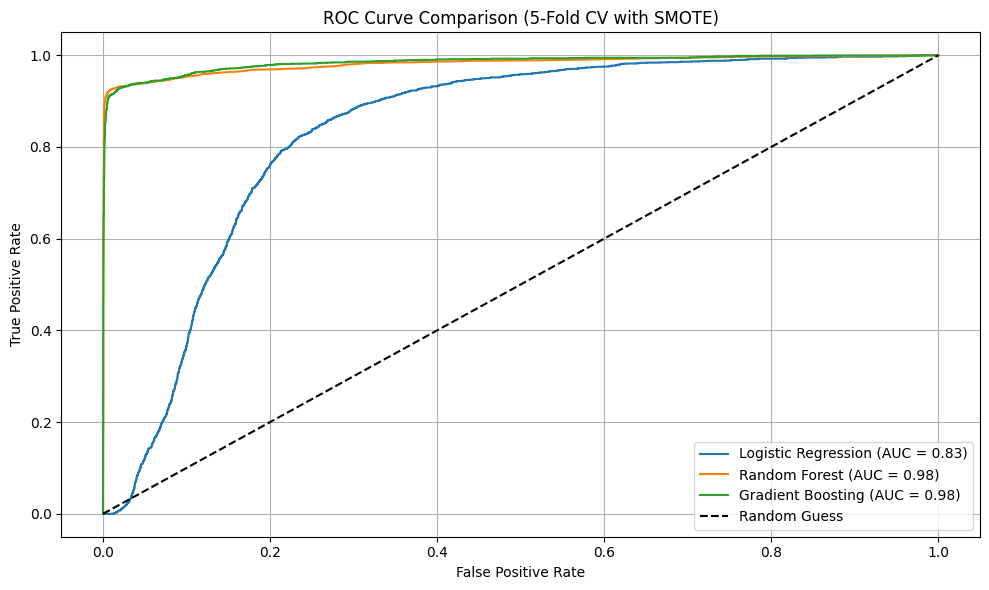

In [17]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot setup
plt.figure(figsize=(10, 6))

for name, model in models.items():
    # Pipeline: SMOTE + model
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        (name.lower().replace(" ", "_"), model)
    ])

    # Get predicted probabilities
    y_proba = cross_val_predict(pipeline, x, y, cv=cv, method='predict_proba')[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y, y_proba)
    auc_score = roc_auc_score(y, y_proba)

    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Final plot formatting
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (5-Fold CV with SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest Classifier and Gradient boosting perform best with AUC of 0.98 each!

5. USING GRADIENT BOOSTING CLASSIFIER TO PREDICT THE PROBABILITY OF EMPLOYEE TURNOVER IN THE TEST DATA.

In [18]:
# Train Grading Boosting Classifier on SMOTE-balanced data
gb = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.1, random_state=42)
gb.fit(x_train_smote, y_train_smote) 

# Predict probabilities on test data
turnover_probs = gb.predict_proba(x_test)[:, 1]  # Probability of class '1' (employee leaving)

#categorizing employees into 4 zones based on probability scores
test_results = pd.DataFrame(data = turnover_probs,columns=['turnover_probs'])

def categorize_zone(prob):
    if prob < 0.20:
        return 'Safe Zone (Green)'
    elif prob < 0.60:
        return 'Low-Risk Zone (Yellow)'
    elif prob < 0.90:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

# Apply categorization
test_results['risk_zone'] = test_results['turnover_probs'].apply(categorize_zone)

# View distribution
zone_counts = test_results['risk_zone'].value_counts()
print("Employee Distribution by Risk Zone:")
print(zone_counts)

Employee Distribution by Risk Zone:
risk_zone
Safe Zone (Green)            1873
High-Risk Zone (Red)          316
Low-Risk Zone (Yellow)        135
Medium-Risk Zone (Orange)      75
Name: count, dtype: int64


Retension Strategies as per risk zone:

High-risk zone: immediate intervention-->personalized retension plans,offer retention bonuses,address workload, recognition gaps

Medium-risk zone: initiate stay interviews to understand concers,provide targeted training or role adjustments

Low-risk zone: coduct regular checkins and feedback sessions,ensure fair compensation and career growth visibility.

Safe-zone: recognize and reward consistency,offer leadership development and mentorship opportunities.